# Reproducing MacFall 2019

In [1]:
RETRAIN_PROBLEM_A = True
RETRAIN_PROBLEM_B = True

In [2]:
import numpy as np
from numpy import linalg
import torch
from torch import nn
from torch import optim
from custombc import Point, DirichletControlPoint, CustomDirichletBoundaryCondition
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.tri as tri
import pickle

## Example Problem A

<img src="problem-a.png" alt="drawing" width="500"/>

In [3]:
def solution_analytical_problem_a(x, y):
    return np.exp(-x)*(x+y**3)

In [4]:
if RETRAIN_PROBLEM_A:
    control_points_problem_a = []
    points_on_each_edge = 41
    # psi(0, y) = y^3
    for point_y in np.linspace(0.0, 1.0, points_on_each_edge):
        point_x = 0.0
        psi = point_y**3
        control_points_problem_a.append(
            DirichletControlPoint(loc=(point_x, point_y), val=psi)
        )
    # psi(1, y) = (1+y^3)/e
    for point_y in np.linspace(0.0, 1.0, points_on_each_edge):
        point_x = 1.0
        psi = (1+point_y**3)/np.e
        control_points_problem_a.append(
            DirichletControlPoint(loc=(point_x, point_y), val=psi)
        )
    # psi(x, 0) = xe^(-x)
    for point_x in np.linspace(0.0, 1.0, points_on_each_edge):
        point_y = 0.0
        psi = point_x*np.exp(-point_x)
        control_points_problem_a.append(
            DirichletControlPoint(loc=(point_x, point_y), val=psi)
        )
    # psi(x, 1) = (e^(-x))(1+x)
    for point_x in np.linspace(0.0, 1.0, points_on_each_edge):
        point_y = 1.0
        psi = np.exp(-point_x) * (1+point_x)
        control_points_problem_a.append(
            DirichletControlPoint(loc=(point_x, point_y), val=psi)
        )
    cdbc_problem_a = CustomDirichletBoundaryCondition( 
        control_points_problem_a, 
        center_point=Point((0.5, 0.5)) 
    )

<IPython.core.display.Javascript object>


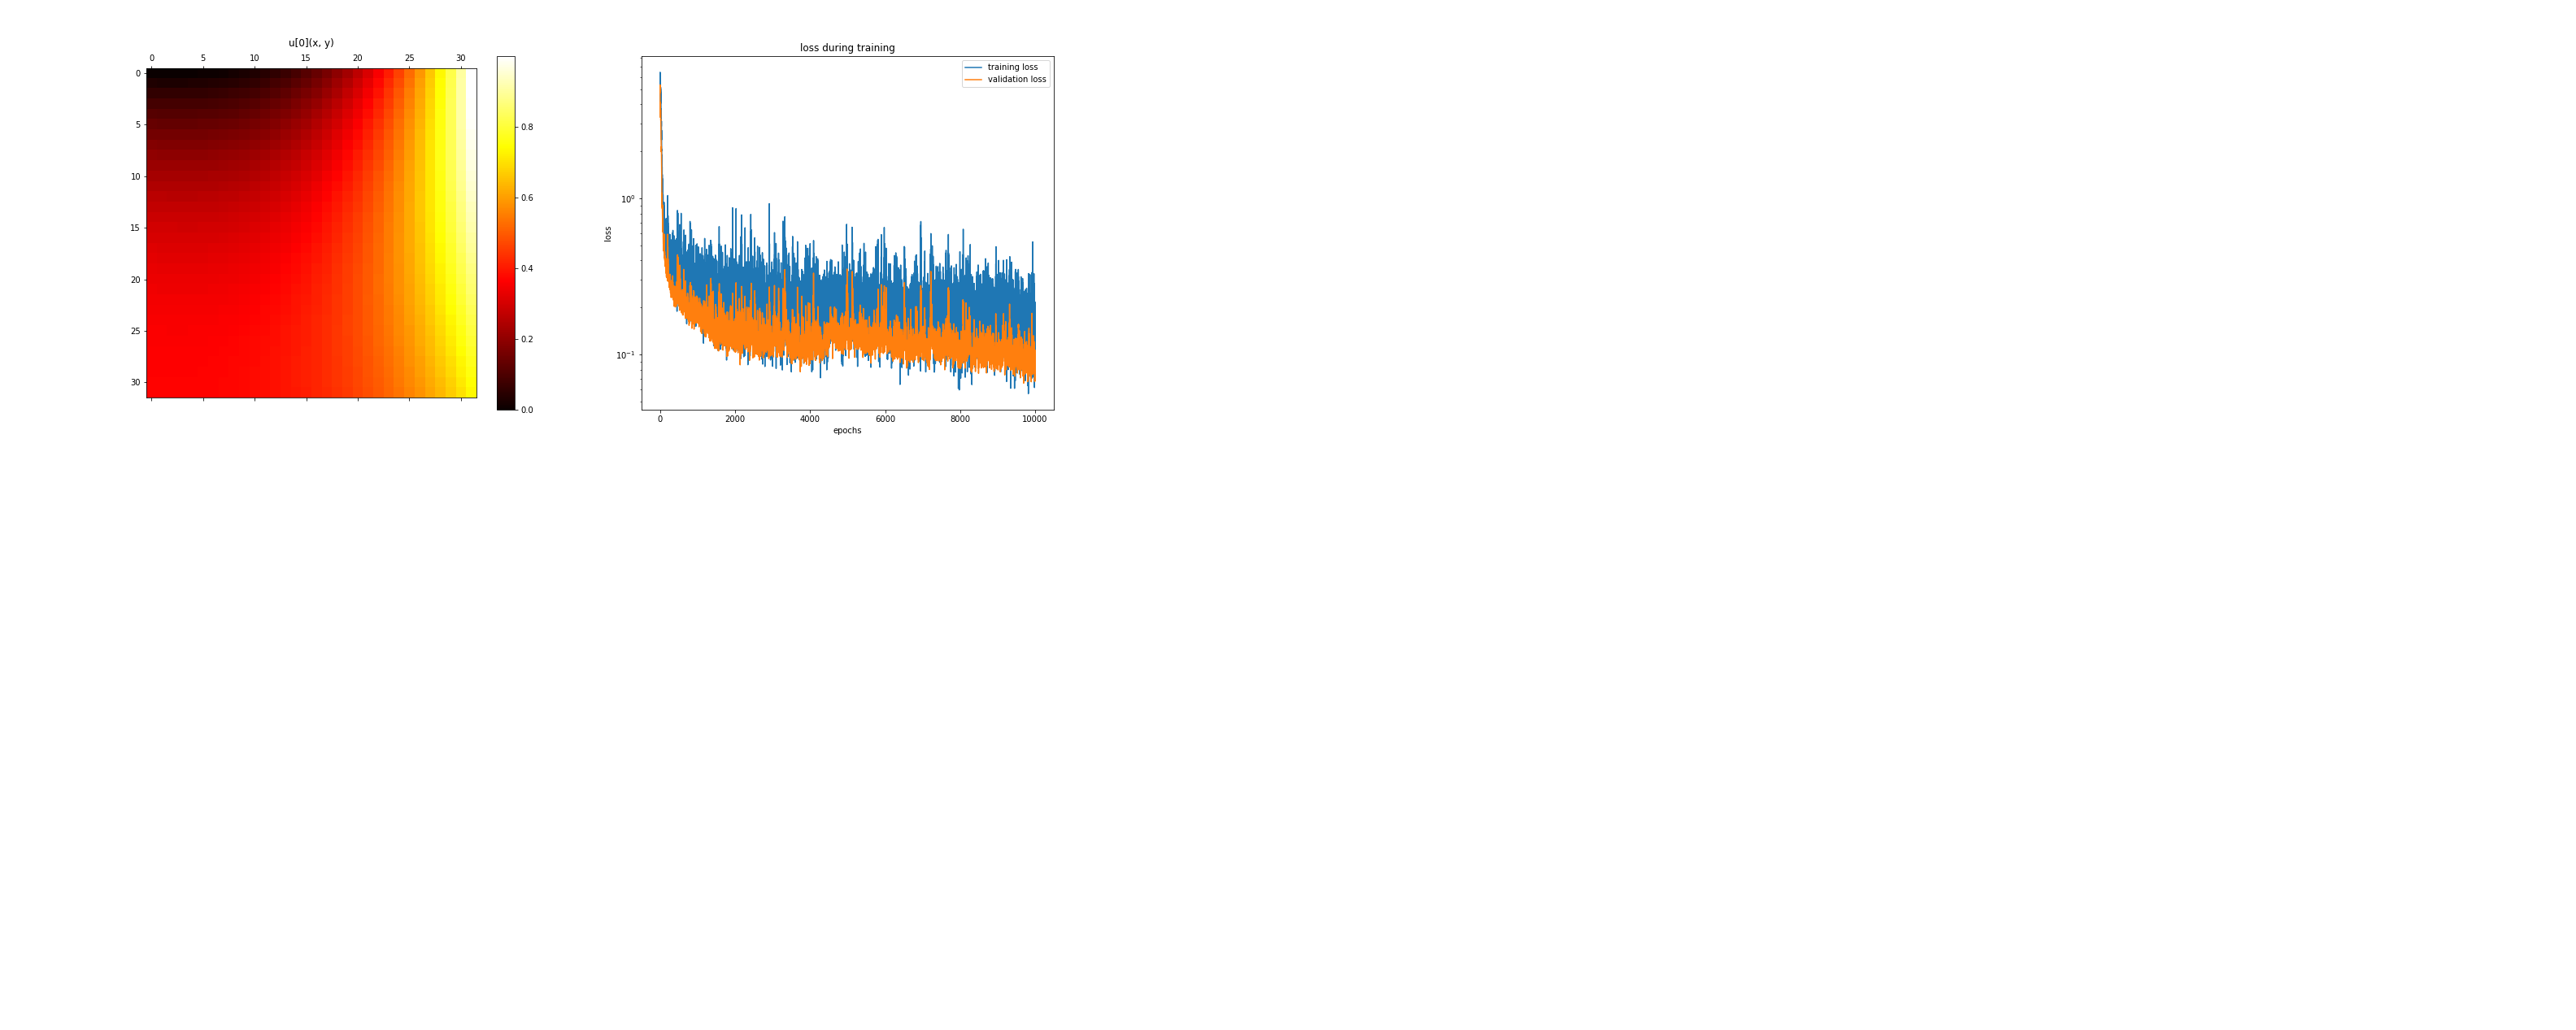

In [5]:
%matplotlib notebook
if RETRAIN_PROBLEM_A:
    # parameters are according to table 1
    # original paper used the 'healed topographical multilevel single linkage global optimization scheme 
    # with the Lev- enberg–Marquardt gradient-descent method as the local search technique' (???)
    # here use Adams instead. also assume batch size = size of the training set
    # original paper used sigmoid activationm here use ELU instead.

    # nabla^2 psi(x, y) = (e^(-x))(x-2+y^3+6y)
    def de_problem_a(u, x, y):
        return diff(u, x, order=2) + diff(u, y, order=2) - torch.exp(-x) * (x - 2 + y**3 + 6*y)

    # fully connected network with one hidden layer (64 hidden units with ELU activation)
    net = FCNN(n_input_units=2, n_hidden_units=64, n_hidden_layers=1, actv=nn.ELU)
    adam = optim.Adam(params=net.parameters(), lr=0.01)

    # train on 32 X 32 grid
    solution_neural_net_problem_a, history_problem_a = solve2D(
        pde=de_problem_a, condition=cdbc_problem_a,
        xy_min=(0, 0), xy_max=(1, 1),
        train_generator=ExampleGenerator2D(
            (32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'
        ),
        valid_generator=ExampleGenerator2D(
            (100, 100), (0, 0), (1, 1), method='equally-spaced-noisy'
        ),
        net=net, max_epochs=10000, batch_size=1024, optimizer=adam,
        monitor=Monitor2D(check_every=1, xy_min=(0, 0), xy_max=(1, 1))
    )
%matplotlib inline

In [6]:
if RETRAIN_PROBLEM_A:
    with open('solution-problem-a', 'wb') as pickle_file:
        pickle.dump(solution_neural_net_problem_a, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('history-problem-a', 'wb') as pickle_file:
        pickle.dump(history_problem_a, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('solution-problem-a', 'rb') as pickle_file:
    solution_neural_net_problem_a = pickle.load(pickle_file)
with open('history-problem-a', 'rb') as pickle_file:
    history_problem_a = pickle.load(pickle_file)

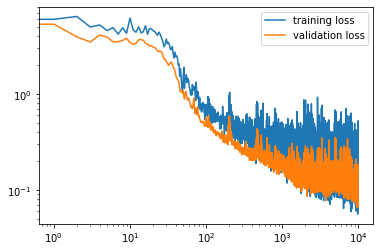

In [8]:
plt.loglog(history_problem_a['train'], label='training loss')
plt.loglog(history_problem_a['valid'], label='validation loss')
plt.legend();

<img src="evaluation.png" alt="drawing" width="500"/>

In [9]:
def get_grid(x_from_to, y_from_to, x_n_points=100, y_n_points=100, as_tensor=False):
    x_from, x_to = x_from_to
    y_from, y_to = y_from_to
    if as_tensor:
        x = torch.linspace(x_from, x_to, x_n_points)
        y = torch.linspace(y_from, y_to, y_n_points)
        return torch.meshgrid(x, y)
    else:
        x = np.linspace(x_from, x_to, x_n_points)
        y = np.linspace(y_from, y_to, y_n_points)
        return np.meshgrid(x, y)

def create_contour(ax, xs, ys, zs, cdbc=None):
    triang = tri.Triangulation(xs, ys)
    xs = xs[triang.triangles].mean(axis=1) 
    ys = ys[triang.triangles].mean(axis=1)
    if cdbc:
        xs, ys = torch.tensor(xs), torch.tensor(ys)
        in_domain = cdbc.in_domain(xs, ys).detach().numpy()
        triang.set_mask(~in_domain)
    
    contour = ax.tricontourf(triang, zs, cmap='coolwarm')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    return contour

def compare_contour(sol_net, sol_ana, eval_on_xs, eval_on_ys, cdbc=None):
    eval_on_xs, eval_on_ys = eval_on_xs.flatten(), eval_on_ys.flatten()
    s_net = sol_net(eval_on_xs, eval_on_ys, as_type='np')
    s_ana = sol_ana(eval_on_xs, eval_on_ys)
    
    fig = plt.figure(figsize=(18, 4))
    
    ax1 = fig.add_subplot(131)
    cs1 = create_contour(ax1, eval_on_xs, eval_on_ys, s_net, cdbc)
    ax1.set_title('ANN-based solution')
    cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)
    
    ax2 = fig.add_subplot(132)
    cs2 = create_contour(ax2, eval_on_xs, eval_on_ys, s_ana, cdbc)
    ax2.set_title('analytical solution')
    cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)
    
    ax3 = fig.add_subplot(133)
    cs3 = create_contour(ax3, eval_on_xs, eval_on_ys, s_net-s_ana, cdbc)
    ax3.set_title('residual of ANN-based solution')
    cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)

def relative_error_norm(sol_net, sol_ana, eval_on_xs, eval_on_ys):
    s_net = sol_net(eval_on_xs, eval_on_ys, as_type='np')
    s_ana = sol_ana(eval_on_xs, eval_on_ys)
    return linalg.norm(s_net-s_ana) / linalg.norm(s_ana)

In [10]:
xx_train, yy_train = get_grid(
    x_from_to=(0, 1), y_from_to=(0, 1), 
    x_n_points=28, y_n_points=28
)
xx_valid, yy_valid = get_grid(
    x_from_to=(0, 1), y_from_to=(0, 1), 
    x_n_points=100, y_n_points=100
)

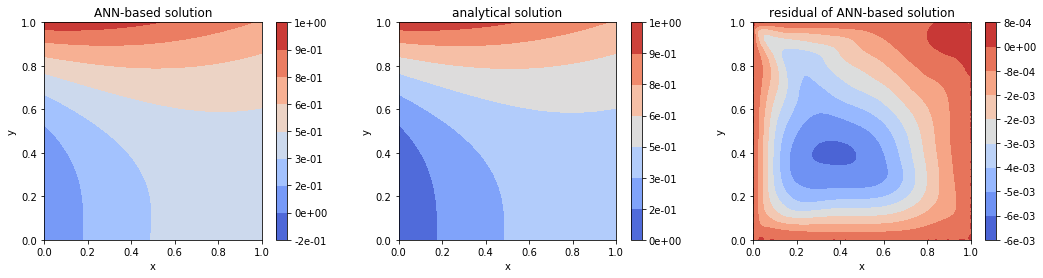

In [11]:
compare_contour(
    solution_neural_net_problem_a, 
    solution_analytical_problem_a,
    xx_valid, yy_valid
)

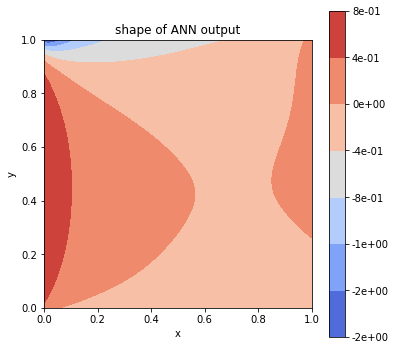

In [12]:
xs, ys = get_grid(
    x_from_to=(0, 1), y_from_to=(0, 1), 
    x_n_points=100, y_n_points=100,
    as_tensor=True
)
xys = torch.cat((xs.reshape(-1, 1), ys.reshape(-1, 1)), 1)
nn_output = solution_neural_net_problem_a.nets[0](xys).detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cs = create_contour(ax, xs.flatten(), ys.flatten(), nn_output.flatten())
ax.set_title('shape of ANN output')
cbar = fig.colorbar(cs, format='%.0e', ax=ax)

In [13]:
xys.shape

torch.Size([10000, 2])

In [14]:
relative_error_norm(
    solution_neural_net_problem_a, 
    solution_analytical_problem_a,
    xx_train, yy_train
)

0.006123068708143228

In [15]:
relative_error_norm(
    solution_neural_net_problem_a, 
    solution_analytical_problem_a,
    xx_valid, yy_valid
)

0.006362604777127675

## Example Problem B

<img src="problem-b-1.png" alt="drawing" width="500"/>
<img src="problem-b-2.png" alt="drawing" width="500"/>
<img src="problem-b-3.png" alt="drawing" width="500"/>

In [16]:
def solution_analytical_problem_b(x, y):
    return np.log(1+x**2+y**2)

In [17]:
edge_length = 2.0 / np.sin(np.pi/3) / 4
points_on_each_edge = 11
step_size = edge_length / (points_on_each_edge-1)

direction_theta  =  np.pi*2/3
left_turn_theta  =  np.pi*1/3
right_turn_theta = -np.pi*2/3

control_points_problem_b = []
point_x, point_y = 0.0, -1.0
for i_edge in range(12):
    for i_step in range(points_on_each_edge-1):
        control_points_problem_b.append(
            DirichletControlPoint(
                loc=(point_x, point_y), 
                val=solution_analytical_problem_b(point_x, point_y)
            )
        ) 
        point_x += step_size*np.cos(direction_theta)
        point_y += step_size*np.sin(direction_theta)
    direction_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta

cdbc_problem_b = CustomDirichletBoundaryCondition( 
    control_points_problem_b, 
    center_point=Point((0.0, 0.0)) 
)

In [18]:
class PredefinedExampleGenerator2D:
    
    def __init__(self, xs, ys, noise=None):
        self.size = len(xs)
        x = torch.tensor(xs, requires_grad=True, dtype=torch.float32)
        y = torch.tensor(ys, requires_grad=True, dtype=torch.float32)
        self.x, self.y = x.flatten(), y.flatten()
        self.noise = noise

    def get_examples(self):
        x_train, y_train = self.x, self.y
        if self.noise:
            x_train = torch.normal(mean=self.x, std=self.noise)
            y_train = torch.normal(mean=self.y, std=self.noise)
        return x_train, y_train

In [19]:
def to_np(tensor):
    return tensor.detach().numpy()

xx_train, yy_train = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=32, y_n_points=32,
    as_tensor=True
)
is_in_domain_train = cdbc_problem_b.in_domain(xx_train, yy_train)
xx_train, yy_train = to_np(xx_train), to_np(yy_train)
xx_train, yy_train = xx_train[is_in_domain_train], yy_train[is_in_domain_train]
train_gen = PredefinedExampleGenerator2D(xx_train, yy_train, noise=0.02)


xx_valid, yy_valid = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=100, y_n_points=100,
    as_tensor=True
)
is_in_domain_valid = cdbc_problem_b.in_domain(xx_valid, yy_valid)
xx_valid, yy_valid = to_np(xx_valid), to_np(yy_valid)
xx_valid, yy_valid = xx_valid[is_in_domain_valid], yy_valid[is_in_domain_valid]
valid_gen = PredefinedExampleGenerator2D(xx_valid, yy_valid)

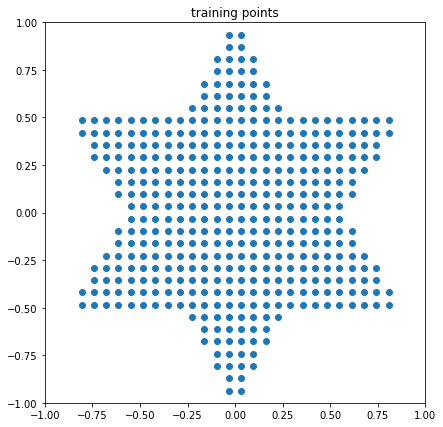

In [20]:
plt.figure(figsize=(7, 7))
plt.scatter(xx_train, yy_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('training points');

<IPython.core.display.Javascript object>


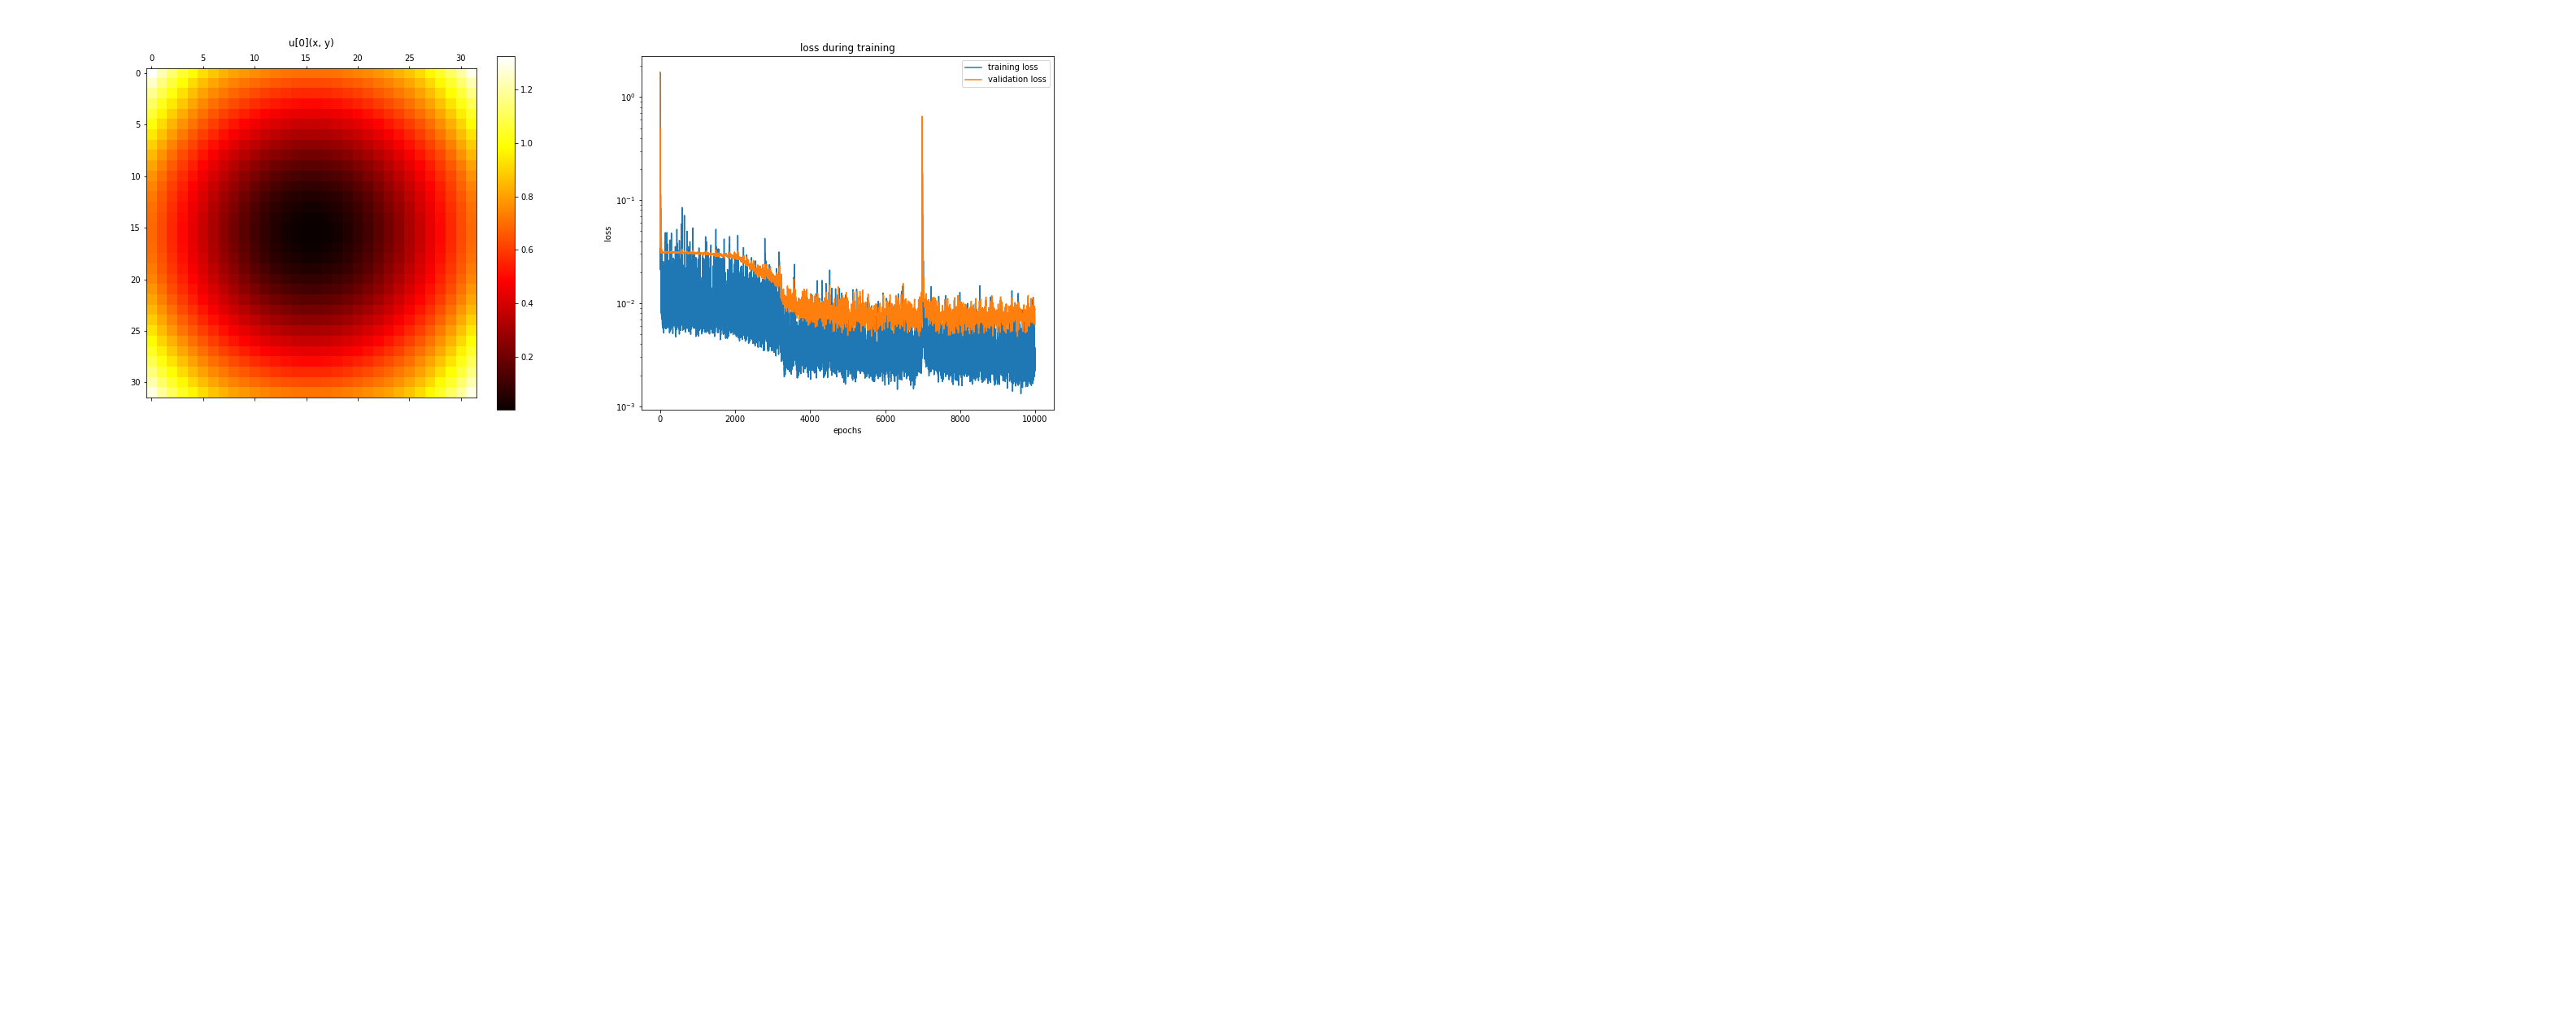

In [21]:
%matplotlib notebook
if RETRAIN_PROBLEM_B:
    # nabla^2 psi(x, y) = (e^(-x))(x-2+y^3+6y)
    def de_problem_b(u, x, y):
        return diff(u, x, order=2) + diff(u, y, order=2) + torch.exp(u) - 1.0 - x**2 - y**2 - 4.0/(1.0+x**2+y**2)**2

    # fully connected network with one hidden layer (64 hidden units with ELU activation)
    net = FCNN(n_input_units=2, n_hidden_units=64, n_hidden_layers=1, actv=nn.ELU)
    adam = optim.Adam(params=net.parameters(), lr=0.01)

    # train on 32 X 32 grid
    solution_neural_net_problem_b, history_problem_b = solve2D(
        pde=de_problem_b, condition=cdbc_problem_b,
        xy_min=(-1, -1), xy_max=(1, 1),
        train_generator=train_gen, valid_generator=valid_gen,
        net=net, max_epochs=10000, batch_size=torch.sum(is_in_domain_train).item(), optimizer=adam,
        monitor=Monitor2D(check_every=1, xy_min=(-1, -1), xy_max=(1, 1))
    )
%matplotlib inline

In [22]:
if RETRAIN_PROBLEM_B:
    with open('solution-problem-b', 'wb') as pickle_file:
        pickle.dump(solution_neural_net_problem_b, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('history-problem-b', 'wb') as pickle_file:
        pickle.dump(history_problem_b, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('solution-problem-b', 'rb') as pickle_file:
    solution_neural_net_problem_b = pickle.load(pickle_file)
with open('history-problem-b', 'rb') as pickle_file:
    history_problem_b = pickle.load(pickle_file)

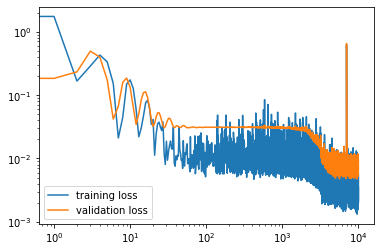

In [24]:
plt.loglog(history_problem_b['train'], label='training loss')
plt.loglog(history_problem_b['valid'], label='validation loss')
plt.legend();

In [25]:
def in_domain_problem_b(xs, ys):
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    ret = cdbc_problem_b.in_domain(xs, ys)
    print(ret.shape)
    return cdbc_problem_b.in_domain(xs, ys)

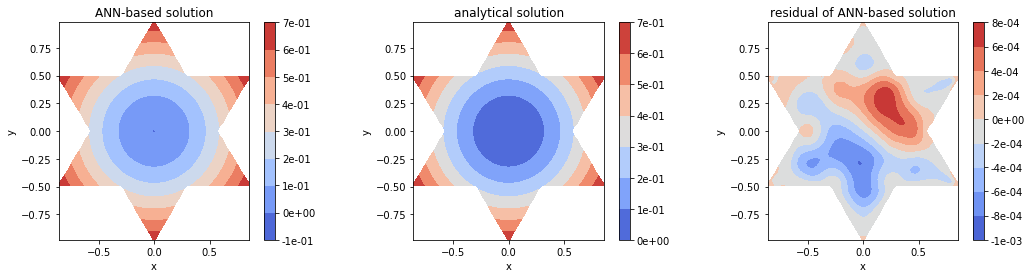

In [26]:
compare_contour(
    solution_neural_net_problem_b, 
    solution_analytical_problem_b,
    xx_valid, yy_valid, cdbc=cdbc_problem_b
)

/opt/anaconda3/envs/nde/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


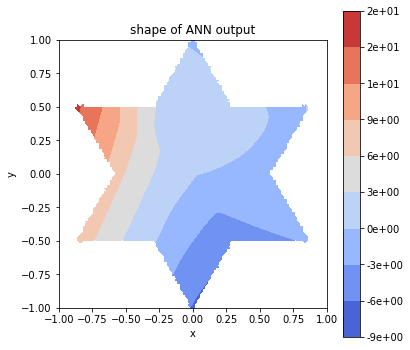

In [27]:
xs, ys = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=100, y_n_points=100,
    as_tensor=True
)
xys = torch.cat((xs.reshape(-1, 1), ys.reshape(-1, 1)), 1)
nn_output = solution_neural_net_problem_a.nets[0](xys).detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cs = create_contour(ax, xs.flatten(), ys.flatten(), nn_output.flatten(), cdbc=cdbc_problem_b)
ax.set_title('shape of ANN output')
cbar = fig.colorbar(cs, format='%.0e', ax=ax)

In [28]:
relative_error_norm(
    solution_neural_net_problem_b, 
    solution_analytical_problem_b,
    xx_train, yy_train
)

0.0011108071

In [29]:
relative_error_norm(
    solution_neural_net_problem_b, 
    solution_analytical_problem_b,
    xx_valid, yy_valid
    
)

0.0011317312